In [107]:
## Configuration
import pandas
import pandas as pd
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from glob import glob
from scipy import stats
from nilearn import datasets, image, input_data, plotting
import scipy
from scipy import io
from tqdm import tqdm
import subprocess
from nilearn import surface
import SUITPy.flatmap as flatmap

import warnings
warnings.filterwarnings('ignore')
git_dir = '/n02dat01/users/ypwang/Gradient/GeneticGradient/Scripts/'
import sys
sys.path.insert(0,git_dir)
%load_ext autoreload
%autoreload 1
%aimport FunctionLibrary

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
atlas = '/n02dat01/users/ypwang/Gradient/GeneticGradient/Data/Cerebellum-MNIfnirt-maxprob-thr25.nii'
aba_dir = '/n01dat01/ypwang/Software/abagen/OriginalData_copy/'
data_dir = '/n02dat01/users/ypwang/Gradient/GeneticGradient/Data'
fig_dir = '/n02dat01/users/ypwang/Gradient/GeneticGradient/Fig/PLSR_2022.09.12/'     
yeo_dir = '/n02dat01/users/ypwang/Gradient/Tool/Atlas/Yeo2011_fcMRI_clustering/1000subjects_reference/'  
dth_dir = '/n04dat04/ypwang/AHBA/CORTICOSTRIATAL_HOLMES-master/CORTICOSTRIATAL_HOLMES-master/data/ThalamusParcellation/'                               

In [110]:
def disbtw(surf, aa):
    surf= np.array(surf)
    aa = np.expand_dims(aa,axis=0)
    dis = np.sqrt(((surf-aa)**2).sum(axis=1))
    return dis

def Grid2world(GridList, affine):
    """
    trans the grid coords into the corresponding MNI coords in MNI space
    GridList shape: N*3, affine shape 4*4
    """
    GridList = np.array(GridList)
    length = len(GridList)
    affine = np.array(affine)
    Grid_coord = np.concatenate([GridList, np.ones([length, 1])], axis=1)
    MNI_coord = Grid_coord.dot(affine.T)      
    MNI_coord = MNI_coord.round(2)
    return MNI_coord[:, :3]

def world2Grid(MNIList, affine):
    """
    trans the MNI coords into the corresponding grid coords in MNI space
    MNIList shape: N*3, affine shape 4*4
    """
    MNIList = np.array(MNIList)
    length = len(MNIList)
    affine = np.array(affine) 
    # t1 = time.time()

    MNI_coord = np.concatenate([MNIList, np.ones([length, 1])], axis=1)

    grid_coord = np.linalg.inv(affine).dot( MNI_coord.T)
    grid_coord = grid_coord.round(0).astype('int').T
    # print('concatenate2:',time.time() - t1)
    
    return grid_coord[:, :3]

color

In [ ]:
# Color bar
from PIL import Image, ImageDraw, ImageFont


def get_dominant_colors(infile):
    image = Image.open(infile)
    
    # 缩小图片，否则计算机压力太大
    small_image = image.resize((80, 80))
    result = small_image.convert(
        "P", palette=Image.ADAPTIVE, colors=10
    )  
	
	# 10个主要颜色的图像

    # 找到主要的颜色
    palette = result.getpalette()
    color_counts = sorted(result.getcolors(), reverse=True)
    colors = list()

    for i in range(10):
        palette_index = color_counts[i][1]
        dominant_color = palette[palette_index * 3 : palette_index * 3 + 3]
        colors.append(tuple(dominant_color))

    # print(colors)
    return colors

def RGB_to_Hex(rgb):
    RGB = rgb.split(',')
    color = '#'
    for i in RGB:
        num = int(i)
        color += str(hex(num))[-2:].replace('x', '0').upper()
    return color


image_path = "/n02dat01/users/ypwang/Gradient/GeneticGradient/Data/FG_noBrainSmash/result_cere2extra_gradient1__z_17853.png"
color_1 = get_dominant_colors(image_path)
print(color_1)
color_rgb = [str(x).replace('(','').replace(')','')  for x in color_1]
Hex_1 = [RGB_to_Hex(x) for x in color_rgb]

image_path = "/n02dat01/users/ypwang/Gradient/GeneticGradient/Fig/Color/红包配色.jpg"
color_2 = get_dominant_colors(image_path)
print(color_2)
color_rgb = [str(x).replace('(','').replace(')','')  for x in color_2]
Hex_2 = [RGB_to_Hex(x) for x in color_rgb]
sns.palplot(Hex_1)
sns.palplot(Hex_2)

from matplotlib import cm
jet_9 = cm.get_cmap('jet', 9)(np.arange(9))
cm.get_cmap('jet', 9)

# 0.0 Run main analysis pipeline to get variables

In [112]:
# expression = pandas.read_csv(os.path.join(data_dir,'expression_4mm_317_cere2extra.csv'), index_col=0)
# report = pandas.read_csv(os.path.join(data_dir,'report_4mm_317_cere2extra.csv'), index_col=0)

# pls_out = PLSR_pipeline(expression,
#                         report['gradient1'], 
#                         clf = PLSRegression(n_components=6),
#                         cv_strategy='score', 
#                         illustrative=True,
#                         test_gene_num = [1, 2, 5, 10, 20, 50, 100,  # sanity check
#                                               200, 500, 1000, 2000, 5000],
#                         sanity_check_style = 'model')

In [113]:
# # Sanity check
# rs = []
# for i,samp in enumerate(expression.T.columns):
#     svec = expression.T[samp]
#     refvec = pls_out['betas']
#     r,p = stats.pearsonr(svec,refvec)
#     rs.append(r)
# plt.close()
# sns.regplot(x=np.array(rs).astype(float).flatten().reshape(-1,1),y=report['gradient1'].values.reshape(-1,1))
# plt.xlim(-0.09,0.025)
# plt.ylim(0,1.02)
# plt.show()
# print(stats.pearsonr(np.array(rs).astype(float).flatten(),report['gradient1'].values))

In [114]:
# # Results spreadsheet
# d_classifiers = pandas.DataFrame(index = np.arange(0.3,0.8,0.05), columns = ['accuracy'])

# # For y-coordinate between 88 and 115...
# for i in np.arange(0.3,0.8,0.05):
#     # separate Cerebellar tissue samples into "non-motor" and "motor"
#     # based on FG1
#     classes = [0 if x < i else 1 for x in report.gradient1]
#     # Run a logistic regression to try to predict split
#     tmod = linear_model.LogisticRegressionCV().fit(np.array(rs).reshape(-1,1),classes)
#     scr = tmod.score(np.array(rs).reshape(-1,1),classes)
#     d_classifiers.loc[i,'accuracy'] = scr
# d_classifiers.loc[:,'distance'] = d_classifiers.index


In [115]:
# # PLOT
# plt.close()
# fig = plt.figure(figsize=(15,10))
# sns.set_context('poster', font_scale=1)
# plt.scatter(x='distance', y='accuracy', data=d_classifiers, c=jet_9[1], s=300)
# sns.despine()
# plt.plot(d_classifiers['distance'], d_classifiers['accuracy'], color = jet_9[1], linewidth=6)
# plt.xticks(d_classifiers['distance'], rotation=90)
# plt.plot([0.65, 0.65], [0.88, 0.94], '--',color=jet_9[8], linewidth=2)
# #plt.savefig(os.path.join(fig_dir,'fmri_cutpoints.pdf'),
# #           bbox_inches='tight')
# plt.show()

# 1.0 The Signifcant Sample

gene

In [116]:
gene_FG1=pd.read_csv(f'{data_dir}/PLS_Betas_cere2extra_15624_permutation.csv', index_col=0)
gene_FG1_sig = gene_FG1.loc[gene_FG1.loc[:,'p_perm_fdr0.05'],:] # 0.05 1024

In [117]:
report_cort= pandas.read_csv(os.path.join(data_dir,'report_RGCI_cort.csv'), index_col=0) 
report_extra= pandas.read_csv(os.path.join(data_dir,'report_RGCI_extra.csv'), index_col=0) 
report_all= pandas.read_csv(os.path.join(data_dir,'report_RGCI_all.csv'), index_col=0) 
report_dth= pandas.read_csv(os.path.join(data_dir,'report_RGCI_dth.csv'), index_col=0) 

# report_cort.index = report_cort.loc[:,'well_id.1']
# report_extra.index = report_extra.well_id
# report_all.index = report_all.well_id
# report_dth.index = report_dth.well_id

In [118]:
# import matplotlib.colors
# from numpy import size
# cset = 'RdBu_r'
# for i in ['FG1', 'FG1_sig']:
#     print(i)
#     gene_cur = eval(f'gene_{i}')
#     for j in [ 'dth', 'cort', 'extra', 'all']:
#         print(j)
#         for k in ['RGCI', 'RGCI_sw']:
#             if k == 'RGCI':
#                 report_cur = eval(f'report_{j}')
#             else:
#                 report_cur = eval(f'report_{j}')
#                 report_cur = report_cur[report_cur[f'p_fdr_sw_{j}_{i}']] 
#             cmap = sns.color_palette(cset,as_cmap=True)
#             norm = matplotlib.colors.Normalize(vmin=report_cur.loc[:,f'RGCI_{j}_{i}'].min(), 
#                                             vmax=report_cur.loc[:,f'RGCI_{j}_{i}'].max())
#             cscale = cmap(norm(report_cur.loc[:,f'RGCI_{j}_{i}'].values))

#             # plot
#             fig = plt.figure(figsize=(10,10))
#             sns.set_style("ticks")
#             g = sns.lmplot(x='mni_y', y='mni_z', legend=True, data=report_cur, fit_reg=False, aspect=1.1,
#                            scatter_kws={"s": 30,'color':cscale}, palette=cset)
#             sns.despine()
#             plt.xlabel('Y', size = 17)
#             plt.ylabel('Z', size = 17)
#             if j == 'cort':
#                 plt.ylim(-60,90)
#                 plt.yticks(list(range(-60,76,25)), size = 15)
#             if j == 'dth':
#                 plt.ylim(-15,30)
#                 plt.yticks(list(range(-15,30,15)), size = 15)
#             else:
#                 plt.ylim(-75,90)
#                 plt.yticks(list(range(-60,76,25)), size = 15)
#             if j == 'dth':
#                 plt.xlim(-40,5)
#                 plt.xticks([-40,-20,0], size = 15)
#             else:
#                 plt.xlim(-115,75)
#                 plt.xticks([-100,-50,0,50], size = 15)
            
#             plt.title(f'{k}_{j}_{i}', size = 20)
#             # plot colorbar
#             colorbar = plt.axes()
#             a = np.array([[0,1]])
#             plt.imshow(a, cmap=cset)
#             plt.gca().set_visible(False)
#             cax = plt.axes([0.95, 0.3, 0.02, 0.5])
#             cbar = plt.colorbar(orientation="vertical", cax=cax)
#             newticks = [round(norm.inverse(x),2) for x in cbar.get_ticks()]
#             cbar.set_ticks(cbar.get_ticks())
#             cbar.set_ticklabels(newticks, size=10)

#             plt.savefig(f'{fig_dir}/Sample_scatter_{k}_{j}_{i}.png',dpi=500, bbox_inches='tight')
#             plt.show()


# 2.0 Cortex

## 2.1 Input to lesion network analysis

Need file

In [119]:
output_dir = "/n02dat01/users/ypwang/Gradient/GeneticGradient/Data/Sigsample2CereFC_lesionnetwork/Data_HCP_U100/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
os.chdir(output_dir)

In [14]:
cmd = f'cp -r /n02dat01/users/ypwang/Gradient/GeneticGradient/Data/Sigsample2CereFC_lesionnetwork/Data_Overlap/Cerebellum_2mm_mask_17853.nii {output_dir}'
subprocess.check_output(cmd, shell=True)
cmd = f'cp -r /n02dat01/users/yfwang/empathy/data/ref_float_2mm.nii.gz {output_dir}'
subprocess.check_output(cmd, shell=True)
cmd = f'cp -r /n02dat01/users/yfwang/empathy/data/ref_float_3mm.nii.gz {output_dir}'
subprocess.check_output(cmd, shell=True)

b''

In [15]:
cmd = f'cp -r /n02dat01/users/ypwang/Gradient/GeneticGradient/Data/Sigsample2CereFC_lesionnetwork/Data_Overlap/Cerebellum_2mm_mask_17853.nii {output_dir}samplewise/'
subprocess.check_output(cmd, shell=True)
cmd = f' cp -r /n02dat01/users/yfwang/empathy/data/ref_float_2mm.nii.gz {output_dir}samplewise/'
subprocess.check_output(cmd, shell=True)


b''

In [16]:
cmd = 'flirt -applyisoxfm 3 -ref /n02dat01/users/yfwang/empathy/data/ref_float_3mm.nii.gz -in Cerebellum_2mm_mask_17853.nii -out Cerebellum_2mm_mask_17853_flirt3mm.nii'
subprocess.check_output(cmd, shell=True)
cere_3mm = nib.load('Cerebellum_2mm_mask_17853_flirt3mm.nii.gz').get_fdata()

Sample_mask = np.zeros_like(cere_3mm)
Sample_mask[cere_3mm!=0] = 1
img = nib.Nifti1Image(Sample_mask, nib.load('Cerebellum_2mm_mask_17853_flirt3mm.nii.gz').affine)
img.to_filename('Cerebellum_2mm_mask_17853_flirt3mm_9298.nii.gz')

In [17]:
# MNI coordinate
# # extra, pos, neg
# # write the mni out as txt for the input to lesion network
# for i in ['FG1', 'FG1_sig']:
#     print(i)
#     gene_cur = eval(f'gene_{i}')
#     for j in [ 'dth', 'cort', 'extra', 'all']:
#         print(j)
#         report_cur = eval(f'report_{j}')
#         report_cur = report_cur[report_cur[f'p_fdr_sw_{j}_{i}']] 
#         report_cur.loc[:, ['mni_x','mni_y','mni_z']].to_csv(f'{j}_{i}_all_MNI.txt', sep='\t', index=False, header=False)
#         report_pos = report_cur[report_cur[f'RGCI_{j}_{i}']>0]
#         report_pos.loc[:, ['mni_x','mni_y','mni_z']].to_csv(f'{j}_{i}_pos_MNI.txt', sep='\t', index=False, header=False)
#         report_neg = report_cur[report_cur[f'RGCI_{j}_{i}']<0]
#         report_neg.loc[:, ['mni_x','mni_y','mni_z']].to_csv(f'{j}_{i}_neg_MNI.txt', sep='\t', index=False, header=False)

In [14]:
template_1mm = nib.load('/n02dat01/users/ypwang/Gradient/AHBA_SampleCorrrected/MNI152_T1_1mm_brain.nii')
template_2mm = nib.load(f'{data_dir}/FG_noBrainSmash/MNI152_T1_2mm_brain.nii')
# template_3mm = nib.load('/n02dat01/users/yfwang/empathy/data/ref_float_3mm.nii.gz')

grid = template_1mm.get_fdata()  # 228453 voxels
MNI_1mm = Grid2world(np.array(np.where(template_1mm.get_fdata()>0)).T, template_1mm.affine)

norad

In [ ]:
# all, pos, neg, 0mm
for i in ['FG1', 'FG1_sig']:
    print(i)
    for k in [ 'dth', 'cort', 'extra']:
        print(k) 
        report_cur = eval(f'report_{k}')
        report_all = report_cur[report_cur[f'p_fdr_sw_{k}_{i}']]
        report_pos = report_all[report_all[f'RGCI_{k}_{i}']>0]
        report_neg = report_all[report_all[f'RGCI_{k}_{i}']<0]
        for j in ['all', 'pos','neg']:
            print(j)
            report_cur = eval(f'report_{j}')
            MNI_cur = report_cur.loc[:, ['mni_x','mni_y','mni_z'] ].values.astype('float')
            tmp_grid = world2Grid(MNI_cur, template_1mm.affine)
            Sample_mask = np.zeros(template_1mm.get_fdata().shape)
            for l in range(len(tmp_grid)):
                Sample_mask[tmp_grid[l][0],tmp_grid[l][1],tmp_grid[l][2]] = 1
            img = nib.Nifti1Image(Sample_mask, template_1mm.affine)
            filename = f'{output_dir}{k}_{i}_{j}_rad0mm_res1mm.nii'
            img.to_filename(filename)

            # resample into 2mm and 3mm, down-sampling
            nii1mmpath = f'{output_dir}{k}_{i}_{j}_rad0mm_res1mm.nii'
            # for res in [2,3]:
            res=2
            niiNEWpath = f'{output_dir}{k}_{i}_{j}_rad0mm_res{res}mm.nii'
            cmd = f'flirt -applyisoxfm {res} -ref /n02dat01/users/yfwang/empathy/data/ref_float_{res}mm.nii.gz -in {nii1mmpath} -out {niiNEWpath}'
            subprocess.check_output(cmd, shell=True)

            # load nii to get coords
            data = nib.load(f'{niiNEWpath}.gz').get_fdata()
            coord = np.array(np.where(data!=0)).T  
            
            if (coord==0).any(1).any(0):
                coord_no0 = coord[~(coord==0).any(1)]    
                print('has 0')
                print(len(coord))
                print(len(coord_no0))
                pd.DataFrame(coord_no0).to_csv(f'{k}_{i}_{j}_rad0mm_res{res}mm_grid.txt', sep='\t', index=False, header=False)
            else:
                print(len(coord))
                pd.DataFrame(coord).to_csv(f'{k}_{i}_{j}_rad0mm_res{res}mm_grid.txt', sep='\t', index=False, header=False)

Generate the list for matlab type input

In [ ]:
# Generate the list for matlab type input
# for res in [2,3]:
res=2
Sample_List=[]
for i in ['FG1', 'FG1_sig']:
    for k in [ 'dth', 'cort', 'extra']:
        print(k) 
        out = f'{output_dir}samplewise/{k}/'
        report_cur = eval(f'report_{k}')
        report_cur= report_cur[report_cur[f'p_fdr_sw_{k}_{i}']]
        for x in tqdm(report_cur.index):
            for mm in [2,4]:
                Sample_List.append(f'{out}{k}_{i}_sample{x}_rad{mm}mm_res{res}mm_grid')
    print(len(Sample_List))
    print(f'SampList_res{res}mm.txt')
    pd.DataFrame(Sample_List).to_csv(f'{output_dir}samplewise/SampList_{k}_{i}_res{res}mm.txt', sep='\t', index=False, header=False)

    # txt split and rename
    cmd_sp = f'split -l 50 {output_dir}samplewise/SampList_{k}_{i}_res{res}mm.txt {output_dir}samplewise/SampList_{k}_{i}_res{res}mm_new_'
    subprocess.check_output(cmd_sp, shell=True)
    cmd_rn = f'n=1; for f in {output_dir}samplewise/SampList_{k}_{i}_res{res}mm_new_*; do mv $f {output_dir}samplewise/SampList_{k}_{i}_res{res}mm_$n.txt; ((n+=1)); done'
    subprocess.check_output(cmd_rn, shell=True)

## 2.2 Overlap: sample wise

In [ ]:
for res in [2,3]:
    print(f'resolution: {res}mm')
    for i in ['FG1', 'FG1_sig']:
        print(i)
        for mm in [2,4]:
            print(f'sphere: {mm}mm')
            report_all= report_cort[report_cort[f'p_fdr_sw_cort_{i}']]
            report_pos = report_all[report_all[f'RGCI_cort_{i}']>0]
            report_neg = report_all[report_all[f'RGCI_cort_{i}']<0]
            for j in ['all', 'pos','neg']:
                print(j)
                report_cur =eval(f'report_{j}')
                plt.close()
                fig = plt.figure(figsize=(15,10))
                for id, l in enumerate(['fdr_0.05', 'fdr_0.01','fdr_0.001', 'fwe_0.05', 'fwe_0.01', 'fwe_0.001']):
                    print(f'threshold: {l}')
                    if res == 2:
                        t_sum = np.zeros([91,109,91])
                    if res == 3:
                        t_sum = np.zeros([61,73,61])
                    for k in tqdm(report_cur.index):
                        t_file = nib.load(f"cort_{i}_sample{k}_rad{mm}mm_res{res}mm_grid_t_{l}.nii.gz")
                        t_data = t_file.get_fdata()
                        t_cur = np.zeros_like(t_data)
                        t_cur[t_data != 0] = 1
                        t_sum = t_sum + t_cur
                    t_ovl = np.zeros_like(t_sum)
                    # t_ovl[t_sum>0] = t_sum[t_sum>0]
                    
                    t_ovl[t_sum>0.5*len(report_cur.index)] = t_sum[t_sum>0.5*len(report_cur.index)]
                    img = nib.Nifti1Image(t_ovl, eval(f'template_{res}mm.affine'))
                    filename = f'cort_{i}_{j}_rad{mm}mm_res{res}mm.nii'
                    img.to_filename(filename)
                    # plot
                    plt.subplot(2,3,id+1)
                    data=flatmap.vol_to_surf(filename)
                    if np.sum(data!=0):
                        data[data==0]=np.nan
                        flatmap.plot(data=data, 
                                    new_figure=False, render='matplotlib',bordersize=0.5,
                                    cmap='jet', colorbar=True
                                    ) # cscale=np.array([np.nanmin(data), np.nanmax(data)]), cscale=np.array([np.nanmin(data_t), abs(np.nanmin(data_t))])
                        plt.subplot(2,3,id+1).set_title(l, x = 0.49, y = 0.9, fontsize=16)
                        
                    else:   
                        print('no overlap')
                        plt.subplot(2,3,id+1).set_title('no overlap', x = 0.49, y = 0.9, fontsize=16)
                plt.suptitle(f'cort_{i}_{j}_{mm}_res{res}mm', y=0.98, fontsize=25)
                plt.savefig(f'../Figure/cort_overlap_{i}_{j}_{mm}_res{res}mm.png',dpi=500, bbox_inches='tight')
                plt.show()

## 2.3 plot

network quantative

pos


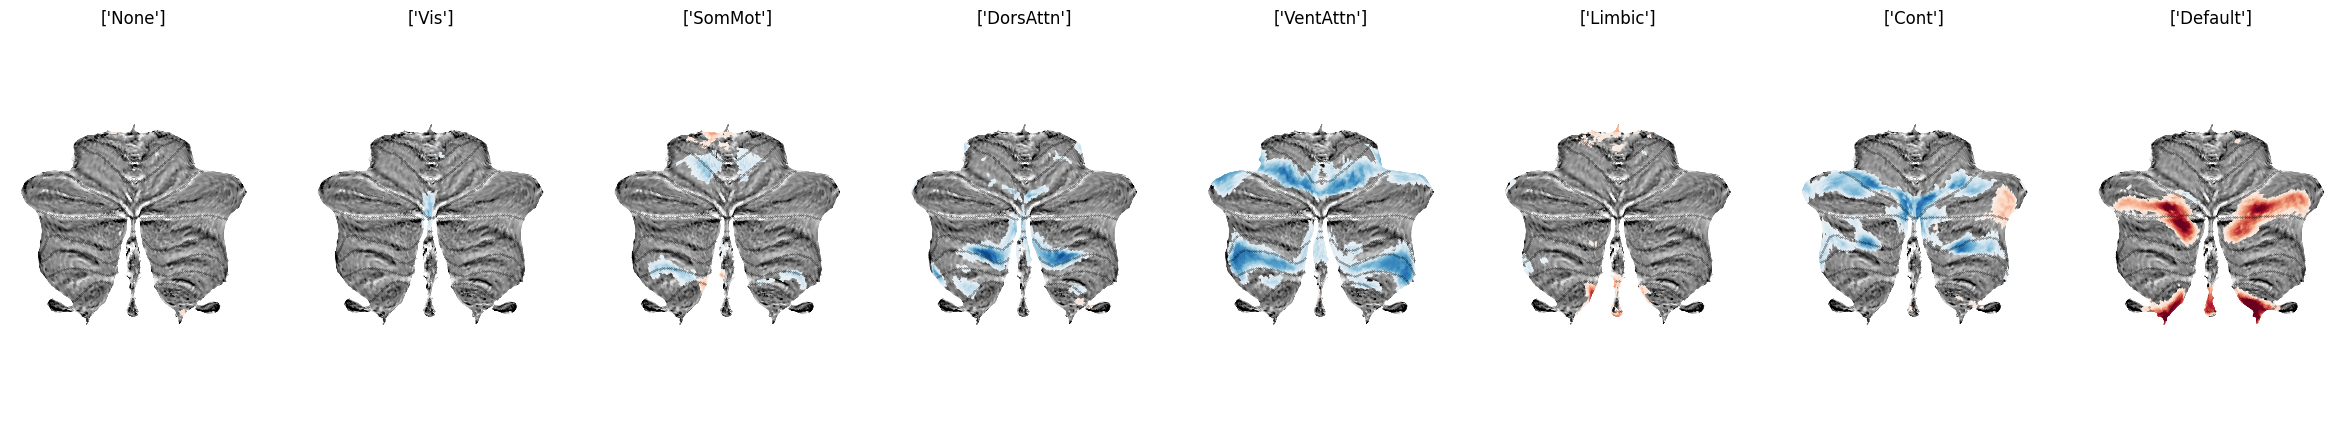

neg


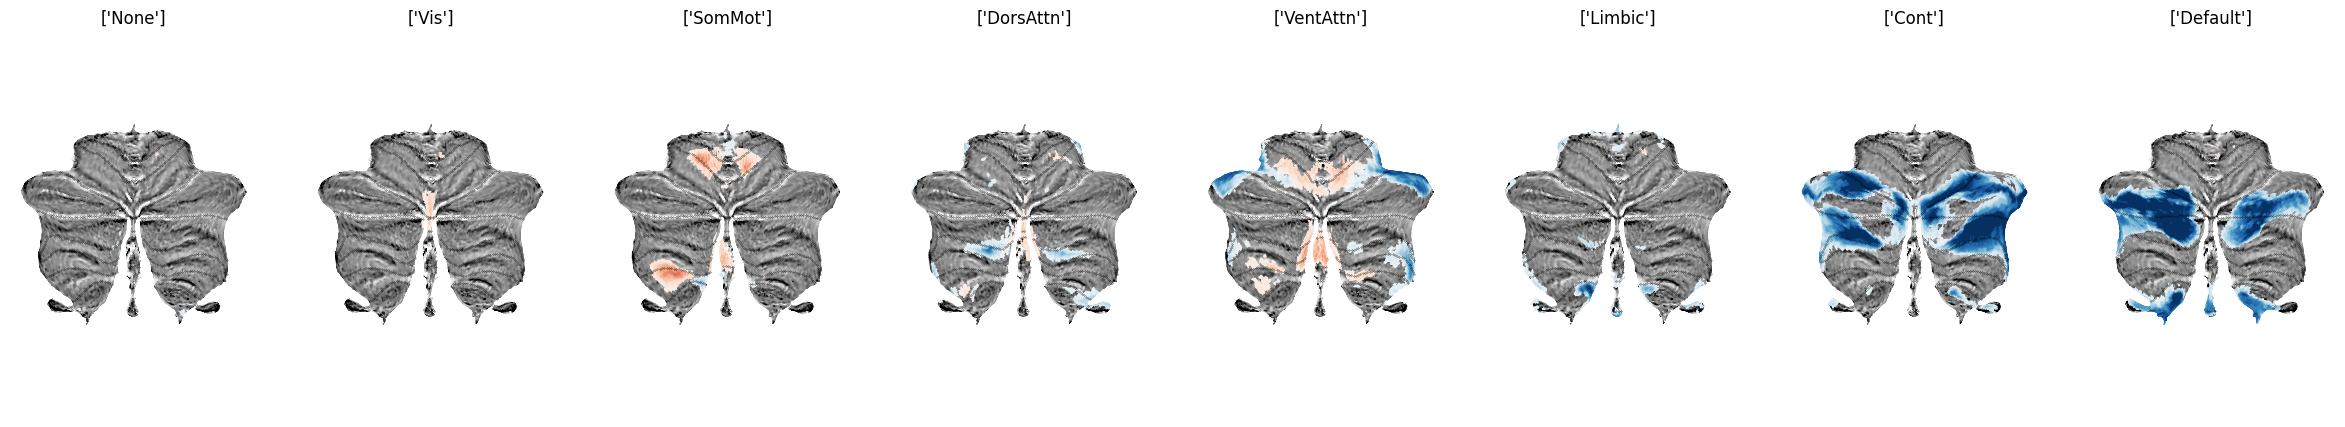

In [127]:
k = 'cort'
i = 'FG1_sig'
mm = 0
res = 2
net_7_name = pd.read_csv('/n02dat01/users/ypwang/AHBA/Github_20220301/Reference_files/buckner7_names.CSV',header=None)
net_17_name = pd.read_csv('/n02dat01/users/ypwang/AHBA/Github_20220301/Reference_files/buckner17_names.csv',header=None)
# for net in [7,17]:
net = 7
atlas_file = nib.load(f'/n14dat01/lchai/HCP_MIN/cere_2mm_{net}.nii.gz')

# 确定亚区的标签值
label_values = np.unique(atlas_file.get_data())


for j in [ 'pos','neg']:
    print(j)
    plt.close()
    fig = plt.figure(figsize=(5*(int(net)-1),5))
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    nii_file = nib.load(f'{k}_{i}_{j}_rad{mm}mm_res{res}mm_grid_t_fwe_0.001.nii.gz')
    for x in label_values:
        mask = atlas_file.get_data()==x
        show = np.zeros(nii_file.get_data().shape)
        show[mask]=nii_file.get_data()[mask]
        img = nib.Nifti1Image(show, nii_file.affine)
        filename = f'{k}_{i}_{j}_rad{mm}mm_res{res}mm_Net{net}_{x}'
        img.to_filename(f'{filename}.nii.gz')

        plt.subplot(1,int(net)+1,x+1)
        data = flatmap.vol_to_surf(f'{filename}.nii.gz')
        data[data==0]=np.nan
        flatmap.plot(data=data,
                new_figure=False, render='matplotlib',bordersize=0.5,
                cmap='RdBu_r', colorbar=False, 
                cscale=np.array([-15,15]))
        plt.subplot(1,int(net)+1,x+1).set_title(eval(f'net_{int(net)}_name').loc[int(x),].values)
        # plt.suptitle(filename, y=0.98, fontsize=25)
    plt.savefig(f'../Figure/{k}_{i}_{j}_rad{mm}mm_res{res}mm_Net{net}.png',dpi=500, bbox_inches='tight')
    plt.show()

pos


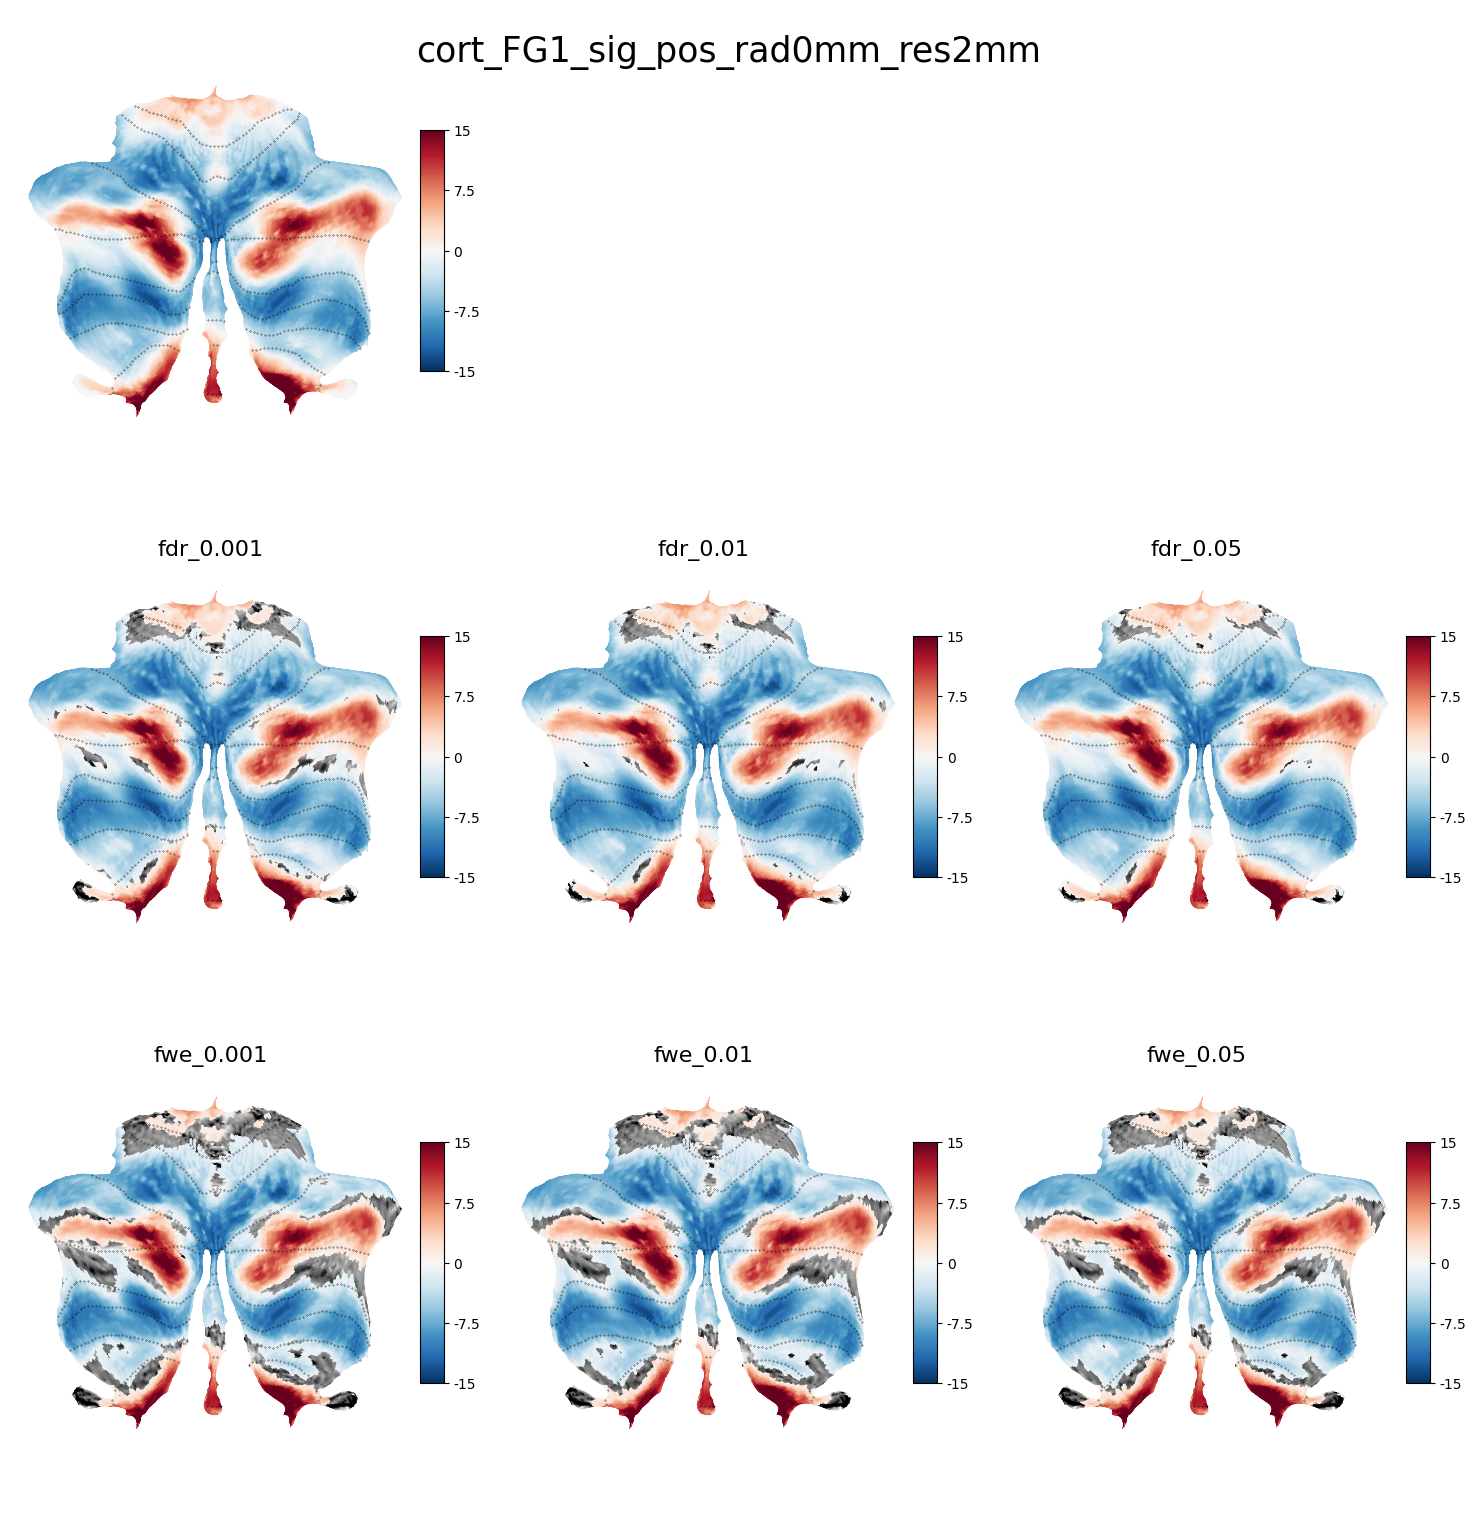

neg


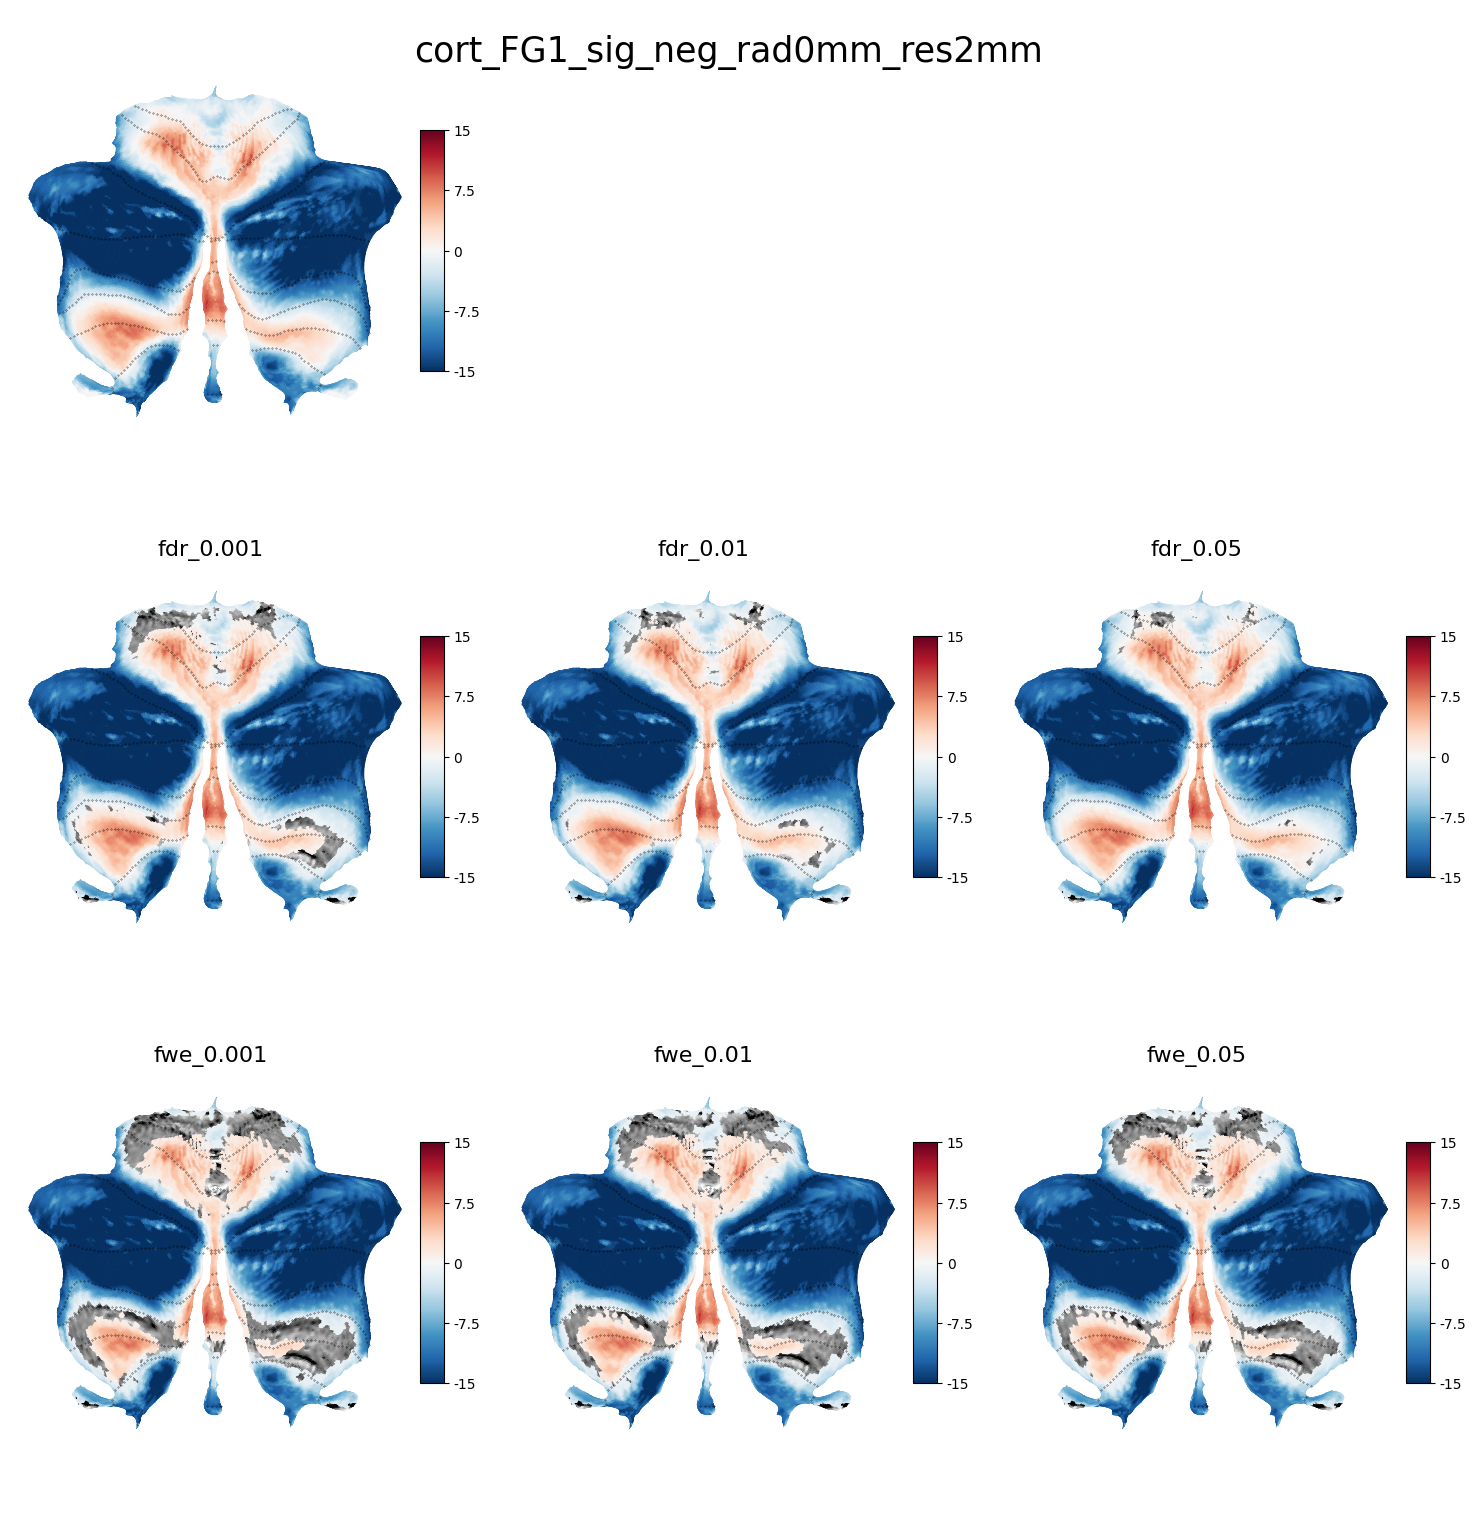

In [128]:
k = 'cort'
i = 'FG1_sig'
mm = 0
res = 2

for j in [ 'pos','neg']:
    print(j)

    # for res in [2,3]:
    plt.close()
    fig = plt.figure(figsize=(15,15))
    plt.subplot(3,3,1)
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    data_t = flatmap.vol_to_surf(f'{k}_{i}_{j}_rad{mm}mm_res{res}mm_grid_t.nii.gz')
    flatmap.plot(data=data_t, 
                new_figure=False, render='matplotlib',bordersize=0.5,
                cmap='RdBu_r', colorbar=True, 
                cscale=np.array([-15,15]))
    for num,m in enumerate(sorted(glob(f'{k}_{i}_{j}_rad{mm}mm_res{res}mm_grid_t_*.nii.gz'))):
        # print(num)
        # print(m)
        plt.subplot(3,3,4+num)
        data=flatmap.vol_to_surf(m)
        data[data==0]=np.nan
        flatmap.plot(data=data,
                    new_figure=False, render='matplotlib',bordersize=0.5,
                    cmap='RdBu_r', colorbar=True,
                    cscale=np.array([-15,15]))
        plt.subplot(3,3,4+num).set_title(m.split('t_')[-1].split('.nii')[0], x = 0.49, y = 0.9, fontsize=16)
    plt.suptitle(f'{k}_{i}_{j}_rad{mm}mm_res{res}mm', y=0.98, fontsize=25)
    plt.savefig(f'../Figure/{k}_{i}_{j}_rad{mm}mm_res{res}mm.png',dpi=500, bbox_inches='tight')
    plt.show()